In [1]:
#%reset -f
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.options.mode.use_inf_as_na = False
pd.option_context('mode.use_inf_as_na', True)

import statistics as stats

import seaborn as sns
%matplotlib inline

import math
from math import(e)

from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve

from scipy.interpolate import interp1d
from collections import defaultdict

from matplotlib_venn import venn3, venn3_circles

C:\Users\eduju\AppData\Local\Temp\ipykernel_38360\2237972626.py:6: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.options.mode.use_inf_as_na = False


In [2]:
listIndex = ['RWI', 'MNDWI', 'NDWI', 'AWEInsh', 'AWEIsh']
listIndexB = ['RWI', 'MNDWI', 'NDWI']
listCity = ['Sao Paulo', 'Curitiba', 'Florianopolis', 'Porto Alegre', 'Buenos Aires', 'Vina del Mar']

In [3]:
import os
path = 'C:\\Users\\eduju\\OneDrive\\Documentos\\Doutorado\\artigos\\ÍndiceÁgua\\ArcGis\\exportFromGEE'
#os.listdir(path)
os.chdir(path)

df_SR = pd.read_csv('samplePointsCities_20240811_harmonized.csv', sep=',', decimal='.')
df_SR.replace([np.inf, -np.inf], np.nan, inplace=True)

def reclassify(value):
    if value == 'water':
        return 1
    if value != 'water':
        return 0

df_SR['surfClass'] = df_SR['surface'].apply(reclassify)

print('Sample points: ',len(df_SR))
print()
print(df_SR.head(1))

Sample points:  123780

       B2      B3      B4     B8     B11     B12          city surface  \
0  0.0199  0.0282  0.0209  0.013  0.0168  0.0149  Vina del Mar   water   

          classWat  surfClass  
0  coastal wetland          1  


### Indices calc

In [4]:
def powe(number):
    return number ** (1 / e)

In [5]:
df_SR['B3Pow']     = df_SR['B3'].apply(powe)

df_SR['RWI'] = 0
df_SR['NDWI']    = (df_SR['B3'] - df_SR['B8'])         / (df_SR['B3'] + df_SR['B8'])
df_SR['MNDWI']   = (df_SR['B3'] - df_SR['B11'])        / (df_SR['B3'] + df_SR['B11'])
#df_SR['RWI']  = (df_SR['B3Pow'] - df_SR['B11'])     / (df_SR['B3Pow'] + df_SR['B11'])

 # AWEIsh =            blue     + 2.5 x    green    - 1.5 x (   Nir      +     Swir1   ) - 0.25 x   Swir2
df_SR['AWEIsh']   = df_SR['B2'] + 2.5 * df_SR['B3'] - 1.5 * (df_SR['B8'] + df_SR['B11']) - 0.25 * df_SR['B12']
 # AWEInsh        = 4 x (   green    -    Swir1    ) - (0.25 x      Nir    + 2.75 x    Swir2    )
df_SR['AWEInsh']  = 4 * (df_SR['B3'] - df_SR['B11']) - (0.25 * df_SR['B8'] + 2.75 * df_SR['B12'])
df_SR['code'] = range(1, len(df_SR) + 1)

print(df_SR.head(1))

       B2      B3      B4     B8     B11     B12          city surface  \
0  0.0199  0.0282  0.0209  0.013  0.0168  0.0149  Vina del Mar   water   

          classWat  surfClass     B3Pow  RWI      NDWI     MNDWI    AWEIsh  \
0  coastal wetland          1  0.269078    0  0.368932  0.253333  0.041975   

    AWEInsh  code  
0  0.001375     1  


In [6]:
cityValue = {}

for city in listCity:
    cityValue[city] = df_SR[df_SR['city'] == city]['B3Pow'].median() / df_SR[df_SR['city'] == city]['B3'].median()

print(cityValue)

df_SR['divider'] = df_SR['city'].map(cityValue)
df_SR['B3powDiv']  = df_SR['B3Pow'] / df_SR['divider']

df_SR['RWI'] = (df_SR['B3powDiv'] - df_SR['B11']) / (df_SR['B3powDiv'] + df_SR['B11'])

print('____________________')

#df_SR.to_excel('df_SR.xlsx') 

unique_cities = df_SR['divider'].unique()
print(df_SR.head(1))

{'Sao Paulo': 5.828770268246491, 'Curitiba': 5.85892560490295, 'Florianopolis': 5.877213189872267, 'Porto Alegre': 5.672592996509505, 'Buenos Aires': 5.877213189872267, 'Vina del Mar': 5.2392623813178965}
____________________
       B2      B3      B4     B8     B11     B12          city surface  \
0  0.0199  0.0282  0.0209  0.013  0.0168  0.0149  Vina del Mar   water   

          classWat  surfClass     B3Pow       RWI      NDWI     MNDWI  \
0  coastal wetland          1  0.269078  0.507028  0.368932  0.253333   

     AWEIsh   AWEInsh  code   divider  B3powDiv  
0  0.041975  0.001375     1  5.239262  0.051358  


#### range of index value

In [7]:
print('RWI: from ',round(df_SR['RWI'].min(), 4),' to ',round(df_SR['RWI'].max(), 4))
print('MNDWI: from ',round(df_SR['MNDWI'].min(), 4),' to ',round(df_SR['MNDWI'].max(), 4))
print('NDWI: from ',round(df_SR['NDWI'].min(), 4),' to ',round(df_SR['NDWI'].max(), 4))
print('AWEIsh: from ',round(df_SR['AWEIsh'].min(), 4),' to ',round(df_SR['AWEIsh'].max(), 4))
print('AWEInsh: from ',round(df_SR['AWEInsh'].min(), 4),' to ',round(df_SR['AWEInsh'].max(), 4))

RWI: from  -0.9423  to  0.997
MNDWI: from  -0.999  to  0.9972
NDWI: from  -0.9968  to  0.9968
AWEIsh: from  -1.0052  to  1.9856
AWEInsh: from  -3.7391  to  1.4946


## Surface reflectance histogram

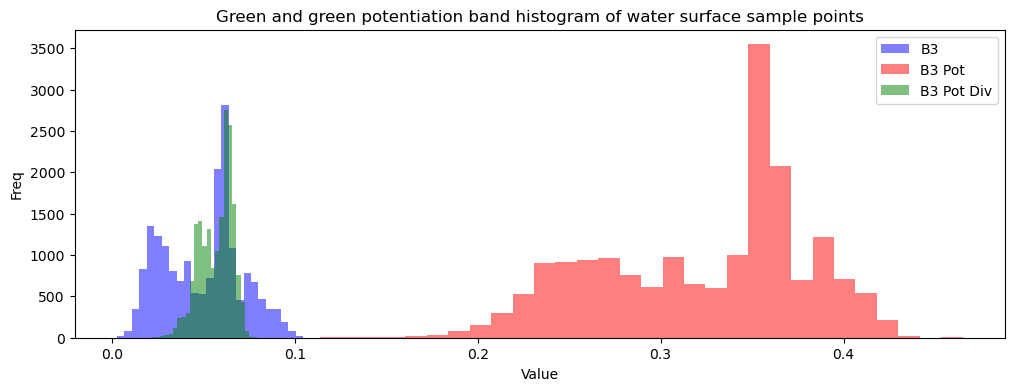

In [8]:
water_SR = df_SR[df_SR['surfClass'] == 1]

B3_SR = water_SR['B3']
B3_SR_exp = water_SR['B3Pow']
B3_SR_expDiv = water_SR['B3powDiv']

plt.figure(figsize=(12,4))
plt.hist(B3_SR, bins=30, alpha=0.5, label='B3', color='blue')
plt.hist(B3_SR_exp, bins=30, alpha=0.5, label='B3 Pot', color='red')
plt.hist(B3_SR_expDiv, bins=30, alpha=0.5, label='B3 Pot Div', color='green')

plt.title('Green and green potentiation band histogram of water surface sample points')
plt.xlabel('Value')
plt.ylabel('Freq')
#plt.xlim([0, 0.5])
plt.legend()
#plt.savefig('Histogram_1_exp', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

## Surface reflectance KDE

In [9]:
def kdePlot(water, nonWater, index):
    plt.figure(figsize=(6,3))
    sns.kdeplot(nonWater,   label = 'non-water', color='red')#, bw_adjust=0.25, cut=0)
    sns.kdeplot(water,      label = 'water'    , color='blue')#  , bw_adjust=0.25, cut=0)

    plt.title(index, fontsize=18)
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Freq', fontsize=14)
    
    plt.xlim([-1.2, 1.2])
    plt.ylim([0, 9])
    plt.legend()
    plt.savefig('KDE_'+index, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


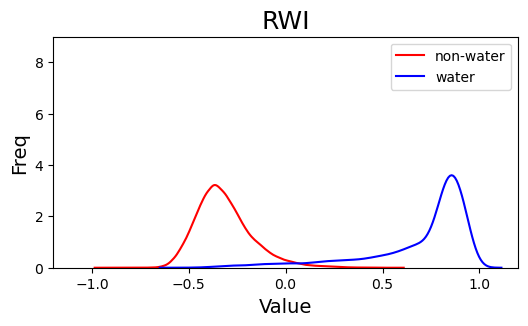

C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


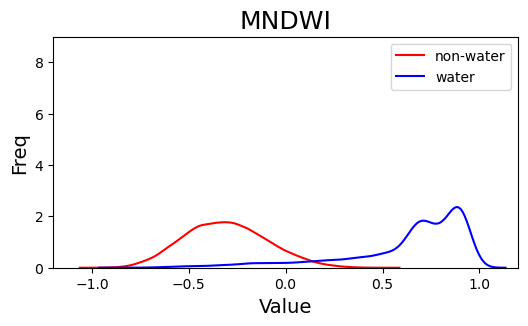

C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


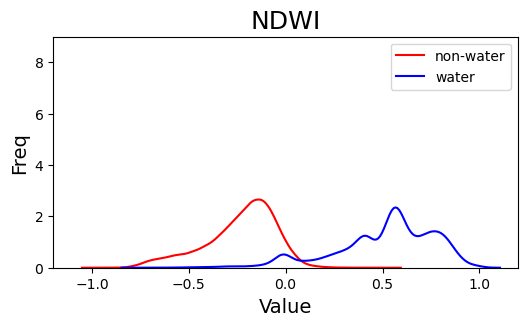

C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


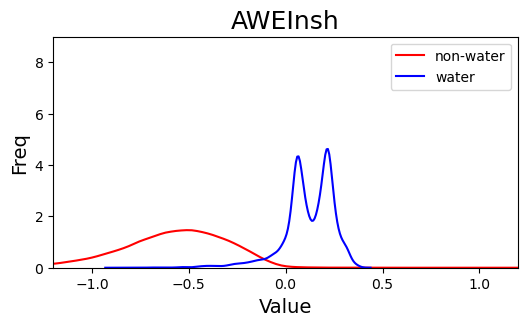

C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\eduju\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


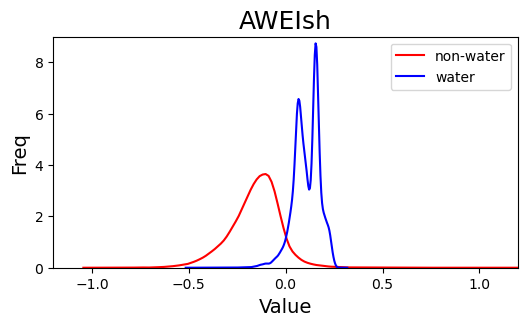

In [10]:
water = df_SR[df_SR['surfClass'] == 1]
nonWater = df_SR[df_SR['surfClass'] != 1]

for index in listIndex:
    waterIndex = water[index]
    nonWaterIndex = nonWater[index]
    kde = kdePlot(waterIndex, nonWaterIndex, index)

### Partial ROC curve

In [11]:
surfClass = df_SR['surfClass'].tolist()
RWI       = df_SR['RWI'].tolist()
MNDWI     = df_SR['MNDWI'].tolist()
NDWI      = df_SR['NDWI'].tolist()
AWEInsh   = df_SR['AWEInsh'].tolist()
AWEIsh    = df_SR['AWEIsh'].tolist()

In [12]:
plt.rcParams['figure.figsize'] = [2, 6]
plt.rcParams['figure.dpi'] = 72
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12  # Font size for x-axis ticks
plt.rcParams['ytick.labelsize'] = 12  # Font size for y-axis ticks

fprThreshold = 0.02
tprThreshold = 0.0

def partial_AUC(Y_true, Y_scores, index, munic):
    if len(Y_true) == 0 or len(Y_scores) == 0:
        raise ValueError("Y_true and Y_scores must not be empty")

    fpr, tpr, thresholds = roc_curve(Y_true, Y_scores)

    # Combinar valores de TPR para o mesmo FPR usando a média
    fpr_tpr_dict = defaultdict(list)
    for f, t in zip(fpr, tpr):
        fpr_tpr_dict[f].append(t)
    
    unique_fpr = np.array(list(fpr_tpr_dict.keys()))
    unique_tpr = np.array([np.mean(tprs) for tprs in fpr_tpr_dict.values()])

    # Adicionar ponto 0.02 se necessário
    if np.max(unique_fpr) < 0.02:
        unique_fpr = np.append(unique_fpr, 0.02)
        unique_tpr = np.append(unique_tpr, interp1d(unique_fpr, unique_tpr, fill_value="extrapolate")(0.02))

    fpr_interval = np.linspace(0, 0.02, num=1000)

    interpolator = interp1d(unique_fpr, unique_tpr, kind='linear', fill_value="extrapolate")
    tpr_interpolated = interpolator(fpr_interval)

    # Substituir possíveis valores NaN por 0
    tpr_interpolated = np.nan_to_num(tpr_interpolated)

    auc_partial = auc(fpr_interval, tpr_interpolated)
    auc_value = auc_partial

    plt.plot(unique_fpr, unique_tpr, label='Curva ROC Original')
    #plt.plot(fpr_interval, tpr_interpolated, label='Curva ROC Interpolada (FPR 0-0.02)', linestyle='--')
    #plt.fill_between(fpr_interval, tpr_interpolated, alpha=0.2, color='b')

    plt.xlabel(f"FPR <= {fprThreshold}", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.xlim([0.0, fprThreshold])
    plt.xticks([0, fprThreshold/2, fprThreshold])
    plt.ylim([tprThreshold, 1])
    plt.yticks([tprThreshold, (1-tprThreshold)/4*1, (1-tprThreshold)/4*2, (1-tprThreshold)/4*3, 1])
    plt.title('pAUC: ' + str(round(auc_value, 5)), fontsize=18)
    #plt.legend(loc="lower right")
    #plt.savefig('Partial_' + munic + '_' + index, dpi=300, bbox_inches='tight', pad_inches=0.1)
    plt.show()

    return auc_value

#### Partial ROC curve for all the cities


Partial Area Under Curve up to 0.02  of FPR - all the cities


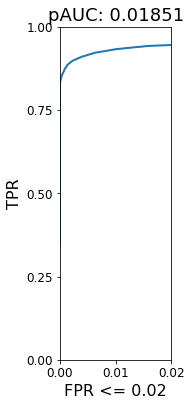

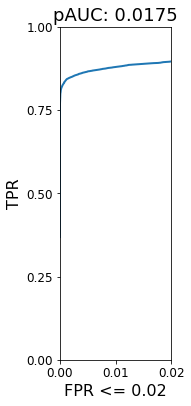

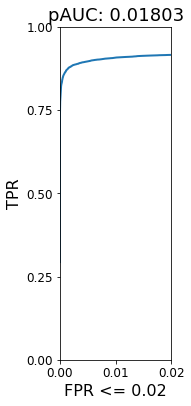

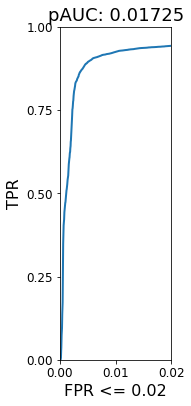

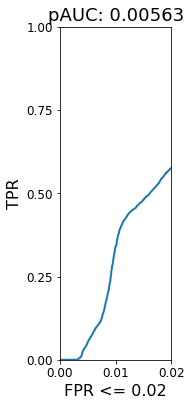


partial auc_RWI: 0.01851
partial auc_MNDWI: 0.0175
partial auc_NDWI: 0.01803
partial auc_AWEInsh: 0.01725
partial auc_AWEIsh: 0.00563


In [13]:
print()
munic = ''
index = ''
print('Partial Area Under Curve up to',fprThreshold,' of FPR - all the cities')

partial_auc_RWI     = partial_AUC(surfClass, RWI,     'RWI',     'allTheCities')
partial_auc_MNDWI   = partial_AUC(surfClass, MNDWI,   'MNDWI',   'allTheCities')
partial_auc_NDWI    = partial_AUC(surfClass, NDWI,    'NDWI',    'allTheCities')
partial_auc_AWEInsh = partial_AUC(surfClass, AWEInsh, 'AWEInsh', 'allTheCities')
partial_auc_AWEIsh  = partial_AUC(surfClass, AWEIsh,  'AWEIsh',  'allTheCities')
print()
print('partial auc_RWI:',     round(partial_auc_RWI,5))
print('partial auc_MNDWI:',   round(partial_auc_MNDWI,5))
print('partial auc_NDWI:',    round(partial_auc_NDWI,5))
print('partial auc_AWEInsh:', round(partial_auc_AWEInsh,5))
print('partial auc_AWEIsh:',  round(partial_auc_AWEIsh,5))

#### Partial ROC curve for each city


Partial Area Under Curve up to 0.02  for Sao Paulo


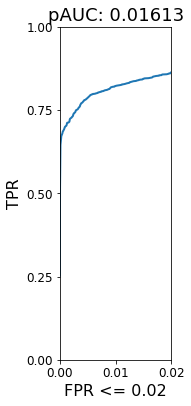

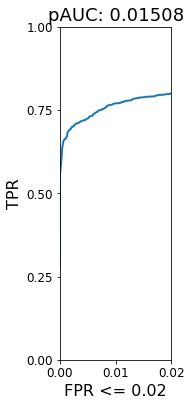

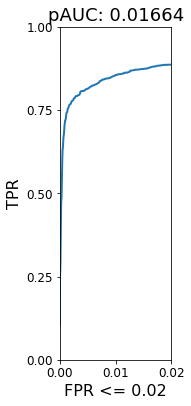

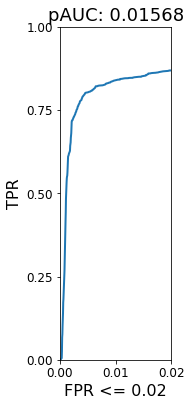

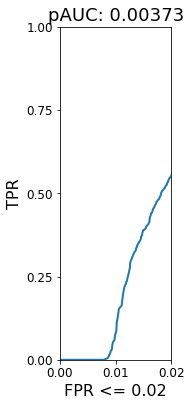


Sao Paulo partial auc_RWI: 0.01613
Sao Paulo partial auc_MNDWI: 0.01508
Sao Paulo partial auc_NDWI: 0.01664
Sao Paulo partial auc_AWEInsh: 0.01568
Sao Paulo partial auc_AWEIsh: 0.00373

Partial Area Under Curve up to 0.02  for Curitiba


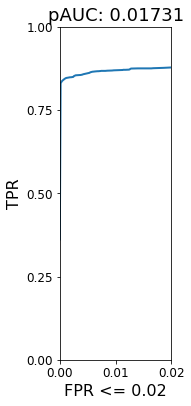

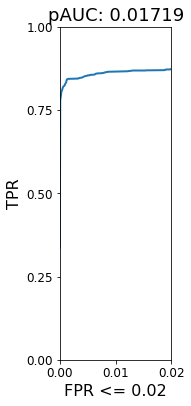

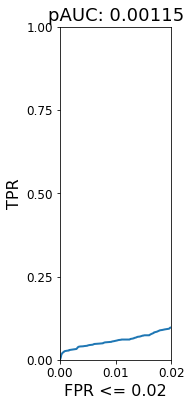

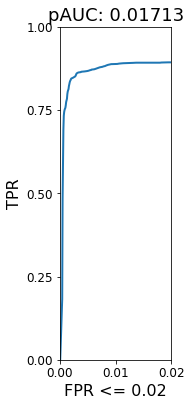

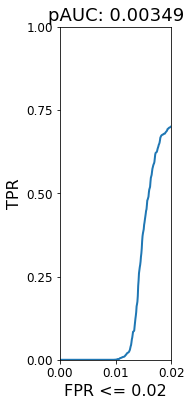


Curitiba partial auc_RWI: 0.01731
Curitiba partial auc_MNDWI: 0.01719
Curitiba partial auc_NDWI: 0.00115
Curitiba partial auc_AWEInsh: 0.01713
Curitiba partial auc_AWEIsh: 0.00349

Partial Area Under Curve up to 0.02  for Florianopolis


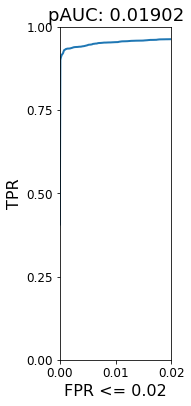

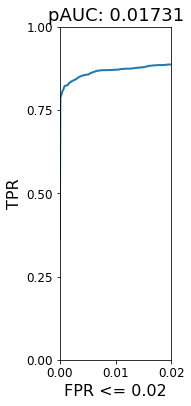

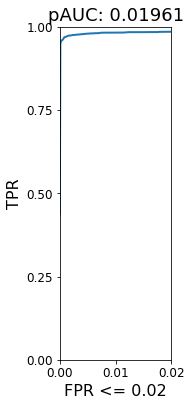

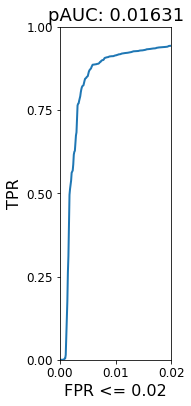

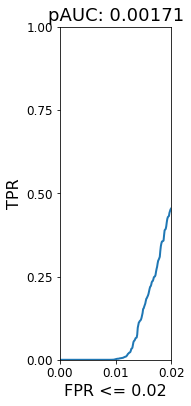


Florianopolis partial auc_RWI: 0.01902
Florianopolis partial auc_MNDWI: 0.01731
Florianopolis partial auc_NDWI: 0.01961
Florianopolis partial auc_AWEInsh: 0.01631
Florianopolis partial auc_AWEIsh: 0.00171

Partial Area Under Curve up to 0.02  for Porto Alegre


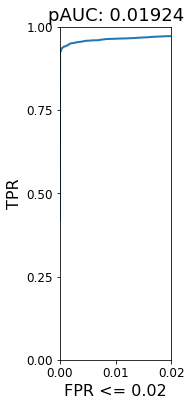

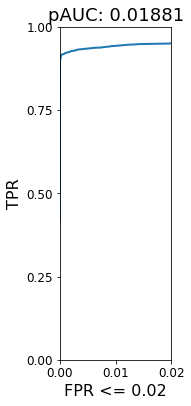

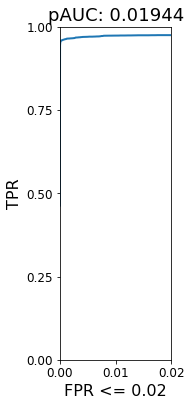

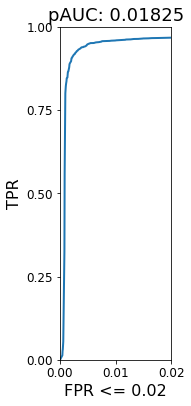

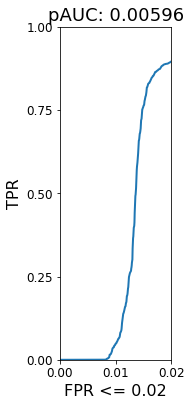


Porto Alegre partial auc_RWI: 0.01924
Porto Alegre partial auc_MNDWI: 0.01881
Porto Alegre partial auc_NDWI: 0.01944
Porto Alegre partial auc_AWEInsh: 0.01825
Porto Alegre partial auc_AWEIsh: 0.00596

Partial Area Under Curve up to 0.02  for Buenos Aires


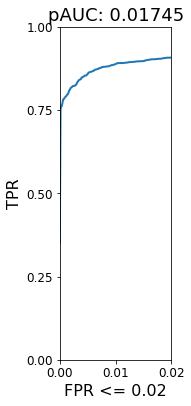

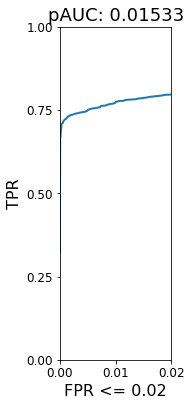

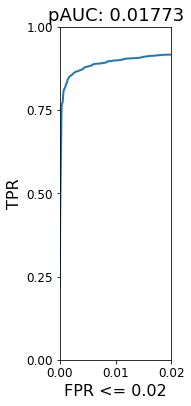

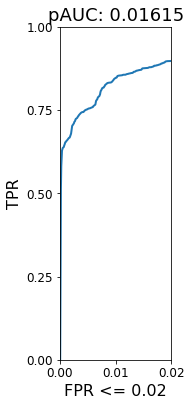

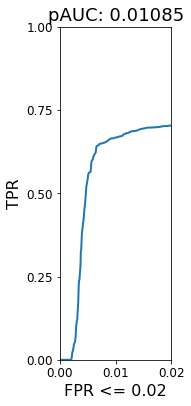


Buenos Aires partial auc_RWI: 0.01745
Buenos Aires partial auc_MNDWI: 0.01533
Buenos Aires partial auc_NDWI: 0.01773
Buenos Aires partial auc_AWEInsh: 0.01615
Buenos Aires partial auc_AWEIsh: 0.01085

Partial Area Under Curve up to 0.02  for Vina del Mar


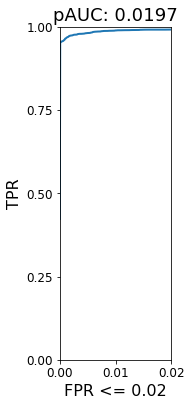

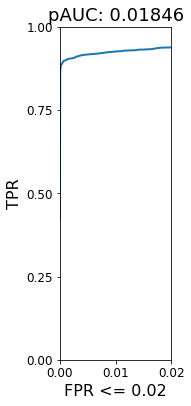

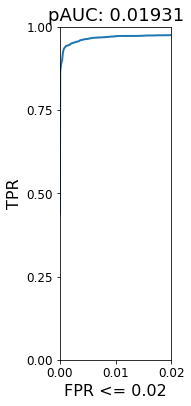

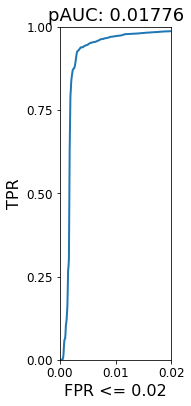

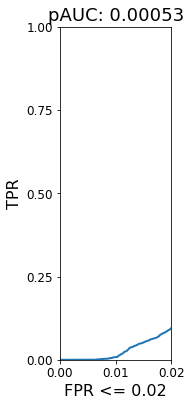


Vina del Mar partial auc_RWI: 0.0197
Vina del Mar partial auc_MNDWI: 0.01846
Vina del Mar partial auc_NDWI: 0.01931
Vina del Mar partial auc_AWEInsh: 0.01776
Vina del Mar partial auc_AWEIsh: 0.00053


In [14]:
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    
    surfClass_city = df_SR_city['surfClass'].tolist()
    RWI_city       = df_SR_city['RWI'].tolist()
    MNDWI_city     = df_SR_city['MNDWI'].tolist()
    NDWI_city      = df_SR_city['NDWI'].tolist()
    AWEInsh_city   = df_SR_city['AWEInsh'].tolist()
    AWEIsh_city    = df_SR_city['AWEIsh'].tolist()

    print()
    print('Partial Area Under Curve up to',fprThreshold,' for',munic)
    partial_auc_RWI_city     = partial_AUC(surfClass_city, RWI_city, 'RWI', munic)
    partial_auc_MNDWI_city   = partial_AUC(surfClass_city, MNDWI_city, 'MNDWI', munic)
    partial_auc_NDWI_city    = partial_AUC(surfClass_city, NDWI_city, 'NDWI', munic)
    partial_auc_AWEInsh_city = partial_AUC(surfClass_city, AWEInsh_city, 'AWEInsh', munic)
    partial_auc_AWEIsh_city  = partial_AUC(surfClass_city, AWEIsh_city, 'AWEIsh', munic)
    print()
    print(munic,'partial auc_RWI:',     round(partial_auc_RWI_city,5))
    print(munic,'partial auc_MNDWI:',   round(partial_auc_MNDWI_city,5))
    print(munic,'partial auc_NDWI:',    round(partial_auc_NDWI_city,5))
    print(munic,'partial auc_AWEInsh:', round(partial_auc_AWEInsh_city,5))
    print(munic,'partial auc_AWEIsh:',  round(partial_auc_AWEIsh_city,5))


### Sample point classification errors by threshold

In [15]:
waterSample = df_SR[df_SR['surfClass'] == 1]
nonWaterSample = df_SR[df_SR['surfClass'] == 0]

##### True positives and true negatives for all the cities (FPR=0)

In [16]:
for index in listIndex:
    threshold = max(nonWaterSample[index])
    print(index+' threshold: '+str(threshold))
    waterList    = df_SR[df_SR['surfClass'] == 1][index]
    nonWaterList = df_SR[df_SR['surfClass'] == 0][index]
    countWater = sum(1 for i in waterList if i > threshold)
    print('Correct '+index+' water classified points in all the cities',countWater,
          '(',round(countWater/len(waterList),5),' - ',round(countWater/len(waterList)*100,2),'%)')
    countNonWater = sum(1 for i in nonWaterList if i <= threshold)
    print('Correct '+index+' non-water classified points in all the cities',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,2), '%)')
    if countWater == 0:
        print(index+' Misclassification points in all the cities:',round(((len(waterList)-countWater+len(nonWaterList)-countNonWater))/(len(waterList)+len(nonWaterList)),4))
        print(index+' Water misclassification points in all the cities (%):',round(100,2))
    elif countWater != 0:
        print(index+' Water misclassification points in all the cities (%):',round((((len(waterList)-countWater))/len(waterList)*100),2))
    print()

RWI threshold: 0.5658038485294847
Correct RWI water classified points in all the cities 14568 ( 0.78669  -  78.67 %)
Correct RWI non-water classified points in all the cities 105262 ( 100.0 %)
RWI Water misclassification points in all the cities (%): 21.33

MNDWI threshold: 0.5236883942766296
Correct MNDWI water classified points in all the cities 13941 ( 0.75284  -  75.28 %)
Correct MNDWI non-water classified points in all the cities 105262 ( 100.0 %)
MNDWI Water misclassification points in all the cities (%): 24.72

NDWI threshold: 0.54
Correct NDWI water classified points in all the cities 10256 ( 0.55384  -  55.38 %)
Correct NDWI non-water classified points in all the cities 105262 ( 100.0 %)
NDWI Water misclassification points in all the cities (%): 44.62

AWEInsh threshold: 1.4946000000000002
Correct AWEInsh water classified points in all the cities 0 ( 0.0  -  0.0 %)
Correct AWEInsh non-water classified points in all the cities 105262 ( 100.0 %)
AWEInsh Misclassification points 

##### True positives by water class and water index (FPR=0)

In [23]:
## Correct by water class
classWater = df_SR['classWat'].unique().tolist()
#print(classWater)
for index in listIndexB:
    print()
    threshold = max(nonWaterSample[index])
    print(index+' threshold: '+str(threshold))
    waterDF = df_SR[df_SR['surfClass'] == 1][[index, 'classWat']]
    for classWat2 in classWater:
        classWaterDF = waterDF[waterDF['classWat'] == classWat2]
        countWater = sum(1 for i in classWaterDF[index] if i > threshold)
        if len(classWaterDF) != 0:
            #print(classWat2)
            print(index+' - '+classWat2+' - points: ',countWater,' of ',len(classWaterDF), 
                  ' (',round(countWater/len(classWaterDF)*100,2),'%)')


RWI threshold: 0.5658038485294847
RWI - coastal wetland - points:  7  of  143  ( 4.9 %)
RWI - reservoir - points:  264  of  445  ( 59.33 %)
RWI - river - points:  14  of  188  ( 7.45 %)
RWI - water treatment plant - points:  0  of  58  ( 0.0 %)
RWI - artificial pond - points:  562  of  1626  ( 34.56 %)
RWI - artificial pond with algae - points:  681  of  855  ( 79.65 %)
RWI - lake - points:  4045  of  4390  ( 92.14 %)
RWI - ocean - points:  3785  of  3996  ( 94.72 %)
RWI - polluted river - points:  383  of  874  ( 43.82 %)
RWI - river mouth - points:  1717  of  1887  ( 90.99 %)
RWI - sea - points:  3110  of  4056  ( 76.68 %)

MNDWI threshold: 0.5236883942766296
MNDWI - coastal wetland - points:  0  of  143  ( 0.0 %)
MNDWI - reservoir - points:  32  of  445  ( 7.19 %)
MNDWI - river - points:  10  of  188  ( 5.32 %)
MNDWI - water treatment plant - points:  0  of  58  ( 0.0 %)
MNDWI - artificial pond - points:  360  of  1626  ( 22.14 %)
MNDWI - artificial pond with algae - points:  726  

#### threshold for each city

In [24]:
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    print('______________________________________________')
    print(munic)

    for index in listIndex:
        df_SR_CityNonWater = df_SR_city[df_SR_city['surfClass'] == 0]
        threshold = max(df_SR_CityNonWater[index])
        print()
#        print(index+' threshold: '+str(round(threshold, 4)))
        print(index+' threshold: '+str(threshold))
        waterList = df_SR_city[df_SR_city['surfClass'] == 1][index]
        print(len(waterList))
        nonWaterList = df_SR_city[df_SR_city['surfClass'] == 0][index]
        countWater = sum(1 for i in waterList if i > threshold)
        print('Correct '+index+' water classified points in '+munic+': ',countWater,
          '(',round(countWater/len(waterList),5),' - ',round(countWater/len(waterList)*100,2),'%)')
        countNonWater = sum(1 for i in nonWaterList if i <= threshold)
        print('Correct '+index+' non-water classified points in '+munic+':',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,1), '%)')
        if countWater == 0:
            print(index+' Misclassification points in '+munic+':',round(((len(waterList)-countWater+len(nonWaterList)-countNonWater))/(len(waterList)+len(nonWaterList)),4))
            print(index+'Water misclassification points in '+munic+'(%):',round(100,2))
        elif countWater != 0:
            print(index+' Water misclassification points in '+munic+'(%):',round((((len(waterList)-countWater))/len(waterList)*100),2))
        print()
        print()

______________________________________________
Sao Paulo

RWI threshold: 0.5658038485294847
1536
Correct RWI water classified points in Sao Paulo:  779 ( 0.50716  -  50.72 %)
Correct RWI non-water classified points in Sao Paulo: 26345 ( 100.0 %)
RWI Water misclassification points in Sao Paulo(%): 49.28



MNDWI threshold: 0.40201567749160133
1536
Correct MNDWI water classified points in Sao Paulo:  853 ( 0.55534  -  55.53 %)
Correct MNDWI non-water classified points in Sao Paulo: 26345 ( 100.0 %)
MNDWI Water misclassification points in Sao Paulo(%): 44.47



NDWI threshold: 0.36030828516377644
1536
Correct NDWI water classified points in Sao Paulo:  378 ( 0.24609  -  24.61 %)
Correct NDWI non-water classified points in Sao Paulo: 26345 ( 100.0 %)
NDWI Water misclassification points in Sao Paulo(%): 75.39



AWEInsh threshold: 0.36112500000000014
1536
Correct AWEInsh water classified points in Sao Paulo:  0 ( 0.0  -  0.0 %)
Correct AWEInsh non-water classified points in Sao Paulo: 26345

##### True positives by water class, water index, and city (FPR=0)

In [28]:
## Correct by water class
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    print('______________________________________________')
    print(munic)
    watPoints = len(df_SR_city[df_SR_city['surfClass'] == 1])
    print(watPoints, 'water points')

    classWater = df_SR_city['classWat'].unique().tolist()
    #print(classWater)
    for index in listIndexB:
        print()
        waterDF = df_SR_city[df_SR_city['surfClass'] == 1][[index, 'classWat']]
        nonWaterList = df_SR_city[df_SR_city['surfClass'] == 0][[index, 'classWat']]
        threshold = max(nonWaterList[index])
        print(index+' threshold: '+str(threshold))
        for classWat2 in classWater:
            classWaterDF = waterDF[waterDF['classWat'] == classWat2]
            countWater = sum(1 for i in classWaterDF[index] if i > threshold)
            if len(classWaterDF) != 0:
                #print(classWat2)
                print(index+' - '+classWat2+' - points: ',countWater,' of ',len(classWaterDF), 
                      '(',round(countWater/len(classWaterDF)*100,2),'%)')

______________________________________________
Sao Paulo
1536 water points

RWI threshold: 0.5658038485294847
RWI - artificial pond - points:  396  of  662 ( 59.82 %)
RWI - polluted river - points:  383  of  874 ( 43.82 %)

MNDWI threshold: 0.40201567749160133
MNDWI - artificial pond - points:  383  of  662 ( 57.85 %)
MNDWI - polluted river - points:  470  of  874 ( 53.78 %)

NDWI threshold: 0.36030828516377644
NDWI - artificial pond - points:  295  of  662 ( 44.56 %)
NDWI - polluted river - points:  83  of  874 ( 9.5 %)
______________________________________________
Curitiba
936 water points

RWI threshold: 0.29511994889653864
RWI - river - points:  0  of  76 ( 0.0 %)
RWI - artificial pond - points:  0  of  5 ( 0.0 %)
RWI - artificial pond with algae - points:  777  of  855 ( 90.88 %)

MNDWI threshold: 0.5236883942766296
MNDWI - river - points:  0  of  76 ( 0.0 %)
MNDWI - artificial pond - points:  0  of  5 ( 0.0 %)
MNDWI - artificial pond with algae - points:  726  of  855 ( 84.91 %)

#### Shadow and other elements influence

In [29]:
nonWater_dictCity = {}
water_dictCity = {}

for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    dictName = f"{munic.replace(' ', ' ')}"

    nonWater_dictCity[dictName] = {}
    water_dictCity[dictName] = {}

    for index in listIndex:
        df_SR_CityNonWater = df_SR_city[df_SR_city['surfClass'] == 0]
        df_SR_CityWater    = df_SR_city[df_SR_city['surfClass'] == 1]
        nonWaterThreshold  = max(df_SR_CityNonWater[index])
        waterThreshold     = min(df_SR_CityWater[index])

        nonWater_dictCity[dictName][index] = {
            'threshold': nonWaterThreshold,
        }

        water_dictCity[dictName][index] = {
            'threshold': waterThreshold,
        }

In [30]:
for munic in listCity:
    print('_________________________________')
    print(munic)
    df_SR_city = df_SR[df_SR['city'] == munic]

    for index in listIndex:
        df_SR_CityNonWater = df_SR_city[df_SR_city['surfClass'] == 0]
        df_SR_CityWater    = df_SR_city[df_SR_city['surfClass'] == 1]
#        print(df_SR_CityNonWater[index])

        nonWater_threshold = nonWater_dictCity[munic][index]['threshold']
        #print(nonWater_threshold)
        water_threshold    = water_dictCity[munic][index]['threshold']
        #print(water_threshold)
        #print('Non-water - '+munic+' - '+index+': '+str(nonWater_threshold))
        #print('Water     - '+munic+' - '+index+': '+str(water_threshold))
        nonWaterList = df_SR_CityNonWater[index].tolist()
#        print(nonWaterList)
        countList = sum(value <= nonWater_threshold and value > water_threshold for value in nonWaterList)
        
        print(index+': water minimum: '+str(round(water_threshold,3))+', non-water maximum: '+str(round(nonWater_threshold,3))+
              ', non-water points in interval: '+str(countList)+' ('+str(round(countList/len(df_SR_CityNonWater)*100,1))+'%)')


_________________________________
Sao Paulo
RWI: water minimum: -0.341, non-water maximum: 0.566, non-water points in interval: 15000 (56.9%)
MNDWI: water minimum: -0.688, non-water maximum: 0.402, non-water points in interval: 26209 (99.5%)
NDWI: water minimum: -0.631, non-water maximum: 0.36, non-water points in interval: 25313 (96.1%)
AWEInsh: water minimum: -0.538, non-water maximum: 0.361, non-water points in interval: 14715 (55.9%)
AWEIsh: water minimum: -0.159, non-water maximum: 0.391, non-water points in interval: 16026 (60.8%)
_________________________________
Curitiba
RWI: water minimum: -0.466, non-water maximum: 0.295, non-water points in interval: 12206 (86.6%)
MNDWI: water minimum: -0.586, non-water maximum: 0.524, non-water points in interval: 11557 (82.0%)
NDWI: water minimum: -0.443, non-water maximum: 0.54, non-water points in interval: 12459 (88.4%)
AWEInsh: water minimum: -0.695, non-water maximum: 0.878, non-water points in interval: 10492 (74.4%)
AWEIsh: water mi

#### Twenty comission points

##### All the cities

In [31]:
for index in listIndex:
    indexValue = nonWaterSample[index].tolist()
    threshold = 0
    def get_tenth_highest_value(indexValue):
        sorted_list = sorted(indexValue, reverse=True)
        return sorted_list[19]
    
    threshold = get_tenth_highest_value(indexValue)
    
    print(index+' threshold: '+str(round(threshold, 16)))
    waterList    = df_SR[df_SR['surfClass'] == 1][index]
    nonWaterList = df_SR[df_SR['surfClass'] == 0][index]
    countWater = sum(1 for i in waterList if i > threshold)
    #print('Correct '+index+' water classified points in all the cities',countWater, '(',round(countWater/len(waterList)*100,2), '%)')
    countNonWater = sum(1 for i in nonWaterList if i <= threshold)
    #print('Correct '+index+' non-water classified points in all the cities',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,2), '%)')
    #print(index+' Misclassification points in all the cities:',(len(waterList)-countWater+len(nonWaterList)-countNonWater))
    if countWater == 0:
        print(index+' Water misclassification points in all the cities(%):',round(100,2))
    elif countWater != 0:
        print(index+' Water misclassification points in all the cities (%):',round((((len(waterList)-countWater))/len(waterList)*100),2))
    print()

RWI threshold: 0.4428783258494233
RWI Water misclassification points in all the cities (%): 15.48

MNDWI threshold: 0.4020156774916013
MNDWI Water misclassification points in all the cities (%): 18.74

NDWI threshold: 0.3105413105413106
NDWI Water misclassification points in all the cities (%): 18.54

AWEInsh threshold: 0.3569
AWEInsh Water misclassification points in all the cities (%): 99.7

AWEIsh threshold: 0.5470250000000001
AWEIsh Water misclassification points in all the cities(%): 100



##### By city

In [32]:
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    print('______________________________________________')
    print(munic)

    for index in listIndex:
        df_SR_CityNonWater = df_SR_city[df_SR_city['surfClass'] == 0]
        def get_tenth_highest_value(indexValue):
            sorted_list = sorted(indexValue, reverse=True)
            return sorted_list[19]

        threshold = get_tenth_highest_value(df_SR_CityNonWater[index].tolist())

        print(index+' threshold: '+str(round(threshold, 16)))
        waterList = df_SR_city[df_SR_city['surfClass'] == 1][index]
        nonWaterList = df_SR_city[df_SR_city['surfClass'] == 0][index]
        countWater = sum(1 for i in waterList if i > threshold)
        #print('Correct '+index+' water classified points in '+munic+':',countWater, '(',round(countWater/len(waterList)*100,1), '%)')
        countNonWater = sum(1 for i in nonWaterList if i <= threshold)
        #print('Correct '+index+' non-water classified points in '+munic+':',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,1), '%)')
        if countWater == 0:
            #print(index+' Misclassification points in '+munic+':',round(((len(waterList)-countWater+len(nonWaterList)-countNonWater))/(len(waterList)+len(nonWaterList)),4))
            print(index+' Water misclassification points in '+munic+'(%):',round(100,2))
        elif countWater != 0:
            print(index+' Water misclassification points in '+munic+'(%):',round((((len(waterList)-countWater))/len(waterList))*100,2))
        print()


______________________________________________
Sao Paulo
RWI threshold: 0.4408519995268975
RWI Water misclassification points in Sao Paulo(%): 30.92

MNDWI threshold: 0.3197229310973387
MNDWI Water misclassification points in Sao Paulo(%): 33.98

NDWI threshold: 0.2124645892351275
NDWI Water misclassification points in Sao Paulo(%): 32.16

AWEInsh threshold: 0.08625
AWEInsh Water misclassification points in Sao Paulo(%): 78.26

AWEIsh threshold: 0.2640749999999999
AWEIsh Water misclassification points in Sao Paulo(%): 100

______________________________________________
Curitiba
RWI threshold: 0.2238509856893319
RWI Water misclassification points in Curitiba(%): 15.06

MNDWI threshold: 0.3223310985043837
MNDWI Water misclassification points in Curitiba(%): 15.6

NDWI threshold: 0.1652892561983471
NDWI Water misclassification points in Curitiba(%): 97.22

AWEInsh threshold: 0.106175
AWEInsh Water misclassification points in Curitiba(%): 19.44

AWEIsh threshold: 0.3012000000000002
AWEIsh 

#### Fifty comission points

##### All the cities

In [34]:
for index in listIndex:
    indexValue = nonWaterSample[index].tolist()
    threshold = 0
    def get_tenth_highest_value(indexValue):
        sorted_list = sorted(indexValue, reverse=True)
        return sorted_list[49]
    
    threshold = get_tenth_highest_value(indexValue)
    
    print(index+' threshold: '+str(round(threshold, 16)))
    waterList    = df_SR[df_SR['surfClass'] == 1][index]
    nonWaterList = df_SR[df_SR['surfClass'] == 0][index]
    countWater = sum(1 for i in waterList if i > threshold)
    #print('Correct '+index+' water classified points in all the cities',countWater, '(',round(countWater/len(waterList)*100,2), '%)')
    countNonWater = sum(1 for i in nonWaterList if i <= threshold)
    #print('Correct '+index+' non-water classified points in all the cities',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,2), '%)')
    #print(index+' Misclassification points in all the cities:',(len(waterList)-countWater+len(nonWaterList)-countNonWater))
    if countWater == 0:
        print(index+' Water misclassification points in all the cities(%):',round(100,2))
    elif countWater != 0:
        print(index+' Water misclassification points in all the cities (%):',round((((len(waterList)-countWater))/len(waterList)*100),2))
    print()

RWI threshold: 0.4064855190793211
RWI Water misclassification points in all the cities (%): 14.07

MNDWI threshold: 0.3730848861283644
MNDWI Water misclassification points in all the cities (%): 17.52

NDWI threshold: 0.265377855887522
NDWI Water misclassification points in all the cities (%): 15.64

AWEInsh threshold: 0.235175
AWEInsh Water misclassification points in all the cities (%): 85.25

AWEIsh threshold: 0.446325
AWEIsh Water misclassification points in all the cities(%): 100



##### By city

In [36]:
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]
    print('______________________________________________')
    print(munic)

    for index in listIndex:
        df_SR_CityNonWater = df_SR_city[df_SR_city['surfClass'] == 0]
        def get_tenth_highest_value(indexValue):
            sorted_list = sorted(indexValue, reverse=True)
            return sorted_list[99]

        threshold = get_tenth_highest_value(df_SR_CityNonWater[index].tolist())

        print(index+' threshold: '+str(round(threshold, 16)))
        waterList = df_SR_city[df_SR_city['surfClass'] == 1][index]
        nonWaterList = df_SR_city[df_SR_city['surfClass'] == 0][index]
        countWater = sum(1 for i in waterList if i > threshold)
        #print('Correct '+index+' water classified points in '+munic+':',countWater, '(',round(countWater/len(waterList)*100,1), '%)')
        countNonWater = sum(1 for i in nonWaterList if i <= threshold)
        #print('Correct '+index+' non-water classified points in '+munic+':',countNonWater, '(',round(countNonWater/len(nonWaterList)*100,1), '%)')
        if countWater == 0:
            #print(index+' Misclassification points in '+munic+':',round(((len(waterList)-countWater+len(nonWaterList)-countNonWater))/(len(waterList)+len(nonWaterList)),4))
            print(index+' Water misclassification points in '+munic+'(%):',round(100,2))
        elif countWater != 0:
            print(index+' Water misclassification points in '+munic+'(%):',round((((len(waterList)-countWater))/len(waterList))*100,2))
        print()
        print()

______________________________________________
Sao Paulo
RWI threshold: 0.3221649245888953
RWI Water misclassification points in Sao Paulo(%): 23.05


MNDWI threshold: 0.2460966542750929
MNDWI Water misclassification points in Sao Paulo(%): 28.39


NDWI threshold: 0.1237721021611002
NDWI Water misclassification points in Sao Paulo(%): 19.27


AWEInsh threshold: -0.016675
AWEInsh Water misclassification points in Sao Paulo(%): 22.01


AWEIsh threshold: 0.1499000000000001
AWEIsh Water misclassification points in Sao Paulo(%): 100


______________________________________________
Curitiba
RWI threshold: 0.1296780882068475
RWI Water misclassification points in Curitiba(%): 13.25


MNDWI threshold: 0.2320064334539606
MNDWI Water misclassification points in Curitiba(%): 13.89


NDWI threshold: 0.0920245398773006
NDWI Water misclassification points in Curitiba(%): 95.09


AWEInsh threshold: -0.049325
AWEInsh Water misclassification points in Curitiba(%): 12.18


AWEIsh threshold: 0.15322499999

### Venn diagram

In [38]:
listIndex2 = ['RWI', 'MNDWI', 'NDWI']

def printVenn3(onlyRWI, onlyMNDWI, onlyNDWI, RWI_MNDWI, RWI_NDWI, MNDWI_NDWI, 
               indexesIntersection, outside, munic):
    percentages = {
        '100': onlyRWI,                                    # RWIe
        '110': round(RWI_MNDWI - indexesIntersection,2),   # RWIe and MNDWI intersection
        '101': round(RWI_NDWI  - indexesIntersection,2),   # RWIe and NDWI intesection
        '011': round(MNDWI_NDWI  - indexesIntersection,2), # MNDWI and NDWI intersection
        '010': onlyMNDWI,                                  # only MNDWI
        '001': onlyNDWI,                                   # only NDWY
        '111': indexesIntersection                         # all the indexes intersection
    }

    print('Only RWI: ', onlyRWI) 
    print('Only MNDWI: ', onlyMNDWI) 
    print('Only NDWI: ', onlyNDWI)
    print('RWI ∩ MNDWI - NDWI :', round(RWI_MNDWI  - indexesIntersection,2))
    print('RWI ∩ NDWI - MNDWI :', round(RWI_NDWI   - indexesIntersection,2))
    print('MNDWI ∩ NDWI - RWI :', round(MNDWI_NDWI - indexesIntersection,2))
    print('RWI ∩ MNDWI ∩ NDWI :', indexesIntersection)
    print('outside: ', round(outside,2))
    # Calcular tamaños de grupos
    sizes = {}
    for key, value in percentages.items():
        sizes[key] = value
    
    # Calcular percentual fora dos conjuntos
    total_percent = 100
    for key, value in percentages.items():
        total_percent -= value
        
    sizes['outside'] = total_percent
    # Criar o diagrama de Venn
    plt.figure(figsize=(6, 6))
# normal quotas
    venn3(subsets=sizes, set_labels=('RWI', 'MNDWI', 'NDWI'), set_colors=("magenta", "yellow", "cyan"), alpha=0.6)
    venn3_circles(subsets=sizes, linewidth=0.5)
# end normal quotas
    
# small quotas
    
#    out = venn3(subsets=sizes, set_labels=('RWI', 'MNDWI', 'NDWI'), set_colors=("magenta", "yellow", "cyan"), alpha=0.6)
#    for text in out.set_labels:
#        text.set_fontsize(1)
#    for x in range(len(out.subset_labels)):
#        if out.subset_labels[x] is not None:
#            out.subset_labels[x].set_fontsize(1)    
            
# end small quotas
    
    plt.title(munic+' Venn diagram', fontsize=12)
    #plt.savefig('VennDiagram_'+munic+'.jpg', dpi=1200)
    plt.show()

##### Set theory for zero false positive for all the cities

Thresholds
RWI:  0.5658038485294847
MNDWI:  0.5236883942766296
NDWI:  0.54

RWI 78.67 %
MNDWI 75.28 %
NDWI 55.38 %


Correct classified 82.84 %
False negative rate: 17.16 %

Only RWI:  3.48
Only MNDWI:  0.73
Only NDWI:  3.17
RWI ∩ MNDWI - NDWI : 23.23
RWI ∩ NDWI - MNDWI : 0.89
MNDWI ∩ NDWI - RWI : 0.25
RWI ∩ MNDWI ∩ NDWI : 51.07
outside:  17.16


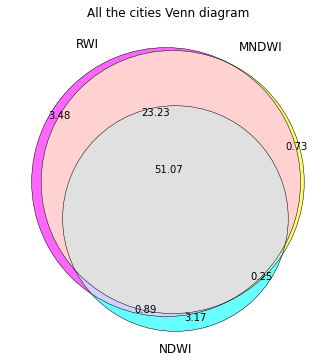

In [39]:
## corrigir ou utilizar o tudoJunto_d
munic = 'All the cities'

waterSample    = df_SR[df_SR['surfClass'] == 1]
nonWaterSample = df_SR[df_SR['surfClass'] == 0]

def threshold(index):
    return max(nonWaterSample[index])

RWI_T = threshold('RWI')
MNDWI_T = threshold('MNDWI')
NDWI_T = threshold('NDWI')

waterList = df_SR[df_SR['surfClass'] == 1]
countWater = round(sum(1 for x, y, z in zip(waterList['RWI'], waterList['MNDWI'], waterList['NDWI']) 
                       if x >= RWI_T or y >= MNDWI_T or z >= NDWI_T)/len(waterSample)*100,2)
outside = round(100-countWater, 2)

indexesIntersection = round(sum(1 for x, y, z in zip(waterList['RWI'], waterList['MNDWI'], waterList['NDWI']) 
                         if x >= RWI_T and y >= MNDWI_T and z >= NDWI_T)/len(waterSample)*100,2)
RWI_MNDWI  = round(sum(1 for x, y in zip(waterList['RWI'], waterList['MNDWI']) 
                        if x > RWI_T and y >= MNDWI_T)/len(waterSample)*100,2)
RWI_NDWI  = round(sum(1 for x, z in zip(waterList['RWI'], waterList['NDWI'])  
                        if x > RWI_T and z >= NDWI_T)/len(waterSample)*100,2)
MNDWI_NDWI  = round(sum(1 for y, z in zip(waterList['MNDWI'],    waterList['NDWI'])  
                        if y > MNDWI_T    and z >= NDWI_T)/len(waterSample)*100,2)

print('Thresholds')
print('RWI: ',RWI_T)
print('MNDWI: ',MNDWI_T)
print('NDWI: ', NDWI_T)
print()

RWI = round(sum(1 for i in waterList['RWI'] if i > RWI_T)/len(waterSample)*100,2)
print('RWI', RWI,'%')
MNDWI = round(sum(1 for i in waterList['MNDWI'] if i > MNDWI_T)/len(waterSample)*100,2)
print('MNDWI', MNDWI,'%')
NDWI = round(sum(1 for i in waterList['NDWI'] if i > NDWI_T)/len(waterSample)*100,2)
print('NDWI', NDWI,'%')

print()
print()
print('Correct classified', countWater,'%')                 
print('False negative rate:',outside,'%')
print()
onlyRWI   = round(RWI   - RWI_MNDWI - RWI_NDWI + indexesIntersection,2)
onlyMNDWI = round(MNDWI - RWI_MNDWI - MNDWI_NDWI + indexesIntersection,2)
onlyNDWI  = round(NDWI  - RWI_NDWI  - MNDWI_NDWI + indexesIntersection,2)

vennDiagram = printVenn3(onlyRWI, onlyMNDWI, onlyNDWI, RWI_MNDWI, RWI_NDWI, 
                         MNDWI_NDWI, indexesIntersection, outside, munic)

##### Set theory for zero false positive for each city

Sao Paulo
Thresholds
RWI:  0.5658038485294847
MNDWI:  0.40201567749160133
NDWI:  0.36030828516377644

RWI 50.72 %
MNDWI 55.53 %
NDWI 24.61 %


Correct classified 60.09 %
False negative rate: 39.91 %

Only RWI:  1.11
Only MNDWI:  5.14
Only NDWI:  3.19
RWI ∩ MNDWI - NDWI : 29.23
RWI ∩ NDWI - MNDWI : 0.26
MNDWI ∩ NDWI - RWI : 1.04
RWI ∩ MNDWI ∩ NDWI : 20.12
outside:  39.91


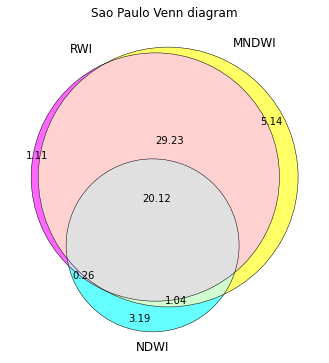

Curitiba
Thresholds
RWI:  0.29511994889653864
MNDWI:  0.5236883942766296
NDWI:  0.54

RWI 83.01 %
MNDWI 77.56 %
NDWI 0.0 %


Correct classified 83.01 %
False negative rate: 16.99 %

Only RWI:  5.45
Only MNDWI:  0.0
Only NDWI:  0.0
RWI ∩ MNDWI - NDWI : 77.56
RWI ∩ NDWI - MNDWI : 0.0
MNDWI ∩ NDWI - RWI : 0.0
RWI ∩ MNDWI ∩ NDWI : 0.0
outside:  16.99


C:\Users\eduju\anaconda3\Lib\site-packages\matplotlib_venn\_venn3.py:61: UserWarning: Circle C has zero area
  warnings.warn("Circle C has zero area")


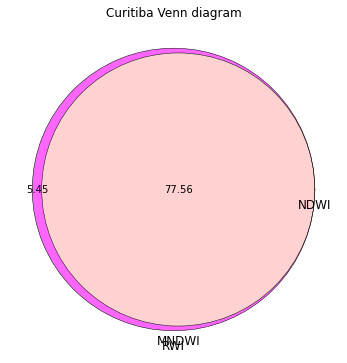

Florianopolis
Thresholds
RWI:  0.23589390937114352
MNDWI:  0.43388942506549005
NDWI:  0.2883031301482702

RWI 89.06 %
MNDWI 78.82 %
NDWI 94.84 %


Correct classified 96.19 %
False negative rate: 3.81 %

Only RWI:  0.95
Only MNDWI:  0.0
Only NDWI:  7.13
RWI ∩ MNDWI - NDWI : 0.4
RWI ∩ NDWI - MNDWI : 9.29
MNDWI ∩ NDWI - RWI : 0.0
RWI ∩ MNDWI ∩ NDWI : 78.42
outside:  3.81


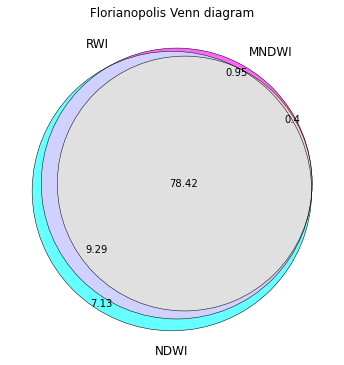

Porto Alegre
Thresholds
RWI:  0.3760940409285803
MNDWI:  0.4803625377643504
NDWI:  0.38116591928251126

RWI 92.28 %
MNDWI 89.8 %
NDWI 93.42 %


Correct classified 95.07 %
False negative rate: 4.93 %

Only RWI:  0.8
Only MNDWI:  0.0
Only NDWI:  2.79
RWI ∩ MNDWI - NDWI : 0.85
RWI ∩ NDWI - MNDWI : 1.68
MNDWI ∩ NDWI - RWI : 0.0
RWI ∩ MNDWI ∩ NDWI : 88.95
outside:  4.93


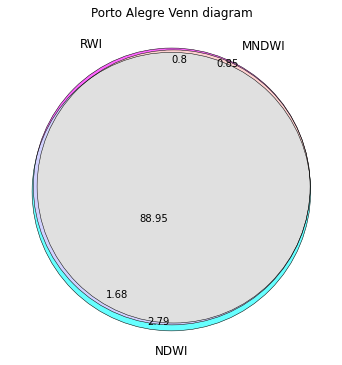

Buenos Aires
Thresholds
RWI:  0.4610488580746752
MNDWI:  0.5135869565217391
NDWI:  0.40803382663847787

RWI 75.19 %
MNDWI 66.06 %
NDWI 40.5 %


Correct classified 78.22 %
False negative rate: 21.78 %

Only RWI:  5.5
Only MNDWI:  0.33
Only NDWI:  2.68
RWI ∩ MNDWI - NDWI : 31.9
RWI ∩ NDWI - MNDWI : 3.99
MNDWI ∩ NDWI - RWI : 0.03
RWI ∩ MNDWI ∩ NDWI : 33.8
outside:  21.78


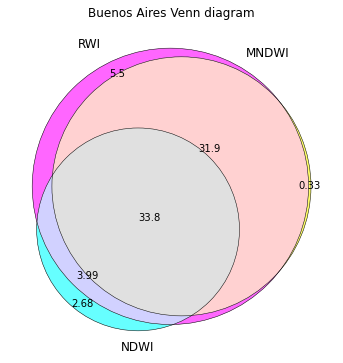

Vina del Mar
Thresholds
RWI:  0.3408467620473778
MNDWI:  0.4308943089430894
NDWI:  0.35942028985507235

RWI 94.96 %
MNDWI 86.13 %
NDWI 86.54 %


Correct classified 96.14 %
False negative rate: 3.86 %

Only RWI:  6.91
Only MNDWI:  0.0
Only NDWI:  1.18
RWI ∩ MNDWI - NDWI : 2.69
RWI ∩ NDWI - MNDWI : 1.92
MNDWI ∩ NDWI - RWI : 0.0
RWI ∩ MNDWI ∩ NDWI : 83.44
outside:  3.86


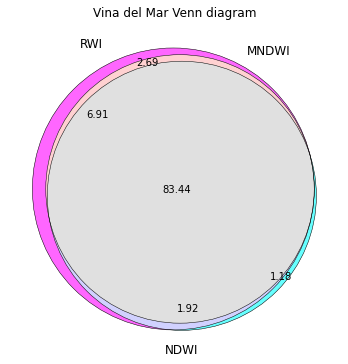

In [40]:
for munic in listCity:
    df_SR_city = df_SR[df_SR['city'] == munic]

    waterSample    = df_SR_city[df_SR_city['surfClass'] == 1]
    nonWaterSample = df_SR_city[df_SR_city['surfClass'] == 0]
    
    def threshold(index):
        return max(nonWaterSample[index])
    
    RWI_T   = nonWater_dictCity[munic]['RWI']['threshold']
    MNDWI_T    = nonWater_dictCity[munic]['MNDWI']['threshold']
    NDWI_T     = nonWater_dictCity[munic]['NDWI']['threshold']
    
    waterList = df_SR_city[df_SR_city['surfClass'] == 1]
    countWater = round(sum(1 for x, y, z in zip(waterList['RWI'], waterList['MNDWI'], waterList['NDWI']) 
                           if x >= RWI_T or y >= MNDWI_T or z >= NDWI_T)/len(waterSample)*100,2)
    outside = round(100-countWater, 2)
    
    indexesIntersection = round(sum(1 for x, y, z in zip(waterList['RWI'], waterList['MNDWI'], waterList['NDWI']) 
                             if x >= RWI_T and y >= MNDWI_T and z >= NDWI_T)/len(waterSample)*100,2)
    RWI_MNDWI  = round(sum(1 for x, y in zip(waterList['RWI'], waterList['MNDWI']) 
                            if x > RWI_T and y >= MNDWI_T)/len(waterSample)*100,2)
    RWI_NDWI  = round(sum(1 for x, z in zip(waterList['RWI'], waterList['NDWI'])  
                            if x > RWI_T and z >= NDWI_T)/len(waterSample)*100,2)
    MNDWI_NDWI  = round(sum(1 for y, z in zip(waterList['MNDWI'],    waterList['NDWI'])  
                            if y > MNDWI_T    and z >= NDWI_T)/len(waterSample)*100,2)
    
    print(munic)
    print('Thresholds')
    print('RWI: ',RWI_T)
    print('MNDWI: ',MNDWI_T)
    print('NDWI: ', NDWI_T)
    print()
    
    RWI = round(sum(1 for i in waterList['RWI'] if i > RWI_T)/len(waterSample)*100,2)
    print('RWI', RWI,'%')
    MNDWI = round(sum(1 for i in waterList['MNDWI'] if i > MNDWI_T)/len(waterSample)*100,2)
    print('MNDWI', MNDWI,'%')
    NDWI = round(sum(1 for i in waterList['NDWI'] if i > NDWI_T)/len(waterSample)*100,2)
    print('NDWI', NDWI,'%')
    
    print()
    #print('Intersections')
    #print('All the index', indexesIntersection,'%')
    #print('RWI and MNDWI', RWI_MNDWI,'%')
    #print('RWI and NDWI', RWI_NDWI,'%')
    #print('MNDWI and NDWI', MNDWI_NDWI,'%')
    print()
    print('Correct classified', countWater,'%')                 
    print('False negative rate:',outside,'%')
    print()
    onlyRWI   = round(RWI   - RWI_MNDWI - RWI_NDWI + indexesIntersection,2)
    onlyMNDWI = round(MNDWI - RWI_MNDWI - MNDWI_NDWI + indexesIntersection,2)
    onlyNDWI  = round(NDWI  - RWI_NDWI  - MNDWI_NDWI + indexesIntersection,2)
    #print('only RWI', onlyRWI)
    #print('only MNDWI', onlyMNDWI)
    #print('only NDWI', onlyNDWI)
    
    vennDiagram = printVenn3(onlyRWI, onlyMNDWI, onlyNDWI, RWI_MNDWI, RWI_NDWI, 
                             MNDWI_NDWI, indexesIntersection, outside, munic)
    
